# Generate scrubbing plots

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nibabel as nib
import pandas as pd
import statsmodels.api as sm
from nilearn import input_data, datasets
from scipy import stats
from scipy.spatial.distance import pdist, squareform

sns.set_style('whitegrid')

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
n_subjects = 31
fd_thresh = 0.05
power = datasets.fetch_coords_power_2011()
coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T
idx = np.triu_indices(coords.shape[0], k=1)
dists = squareform(pdist(coords))
dists = dists[idx]

data = datasets.fetch_adhd(n_subjects=n_subjects)
spheres_masker = input_data.NiftiSpheresMasker(
    seeds=coords, smoothing_fwhm=4, radius=5.,
    detrend=True, standardize=True, low_pass=0.1,
    high_pass=0.01, t_r=2.5)

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/nilearn/datasets/func.py:501: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)


In [3]:
def get_fd(motion):
    # assuming rotations in degrees
    motion[:, :3] = motion[:, :3] * (np.pi/180.) * 50
    motion = np.vstack((np.array([[0, 0, 0, 0, 0, 0]]),
                        np.diff(motion, axis=0)))
    fd = np.sum(np.abs(motion), axis=1)
    return fd

def scrubbing_plot(ts, fd, xyz, fd_thresh=0.2):
    idx = np.triu_indices(xyz.shape[0], k=1)
    dists = squareform(pdist(xyz))
    dists = dists[idx]
    raw_corrs = np.corrcoef(ts)
    raw_corrs = raw_corrs[idx]
    
    scrubbed_ts = ts[:, fd<=fd_thresh]
    scrubbed_corrs = np.corrcoef(scrubbed_ts)
    scrubbed_corrs = scrubbed_corrs[idx]
    
    y = scrubbed_corrs - raw_corrs
    X = dists[:, None]
    X = sm.add_constant(X, prepend=False)
    mod = sm.OLS(y, X)
    res = mod.fit()
    m, b = res.params

In [4]:
ts_all = []
fd_all = []

for i in range(n_subjects):
    func = data.func[i]
    conf = data.confounds[i]
    ts_all.append(spheres_masker.fit_transform(func).T)
    
    df = pd.read_csv(conf, sep='\t')
    motion = df[['motion-pitch', 'motion-roll', 'motion-yaw',
                 'motion-x', 'motion-y', 'motion-z']].values
    fd_all.append(get_fd(motion))

In [5]:
ys = []
slopes = []
intercepts = []

for subj in range(n_subjects):
    raw_ts = ts_all[subj]
    fd = fd_all[subj]
    scrubbed_ts = raw_ts[:, fd<=fd_thresh]
    
    raw_corrs = np.corrcoef(raw_ts)
    raw_corrs = raw_corrs[idx]
    scrubbed_corrs = np.corrcoef(scrubbed_ts)
    scrubbed_corrs = scrubbed_corrs[idx]

    # Fit linear model
    y = raw_corrs - scrubbed_corrs  # opposite of Power
    ys.append(y)
    X = dists[:, None]
    X = sm.add_constant(X, prepend=False)
    mod = sm.OLS(y, X)
    res = mod.fit()
    m, b = res.params
    slopes.append(m)
    intercepts.append(b)

all_ys = np.vstack(ys)
mean_y = np.mean(all_ys, axis=0)

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


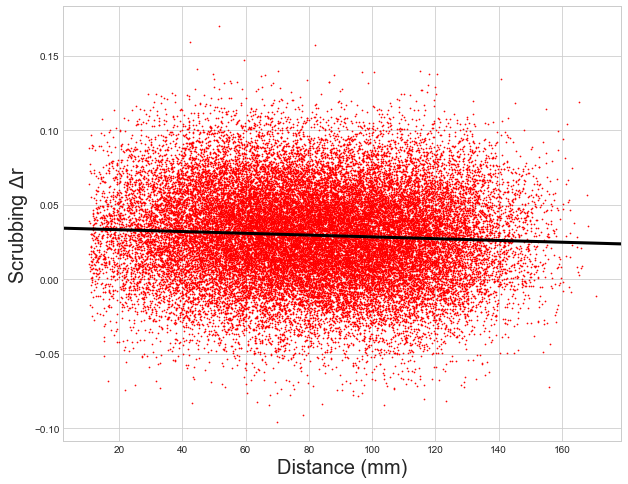

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.regplot(dists, mean_y, ax=ax, scatter=True, #lowess=True,
            line_kws={'color': 'black', 'linewidth': 3},
            scatter_kws={'color': 'red', 's': 0.5, 'alpha': 1})
ax.set_xlabel('Distance (mm)', fontsize=20)
ax.set_ylabel(r'Scrubbing $\Delta$r', fontsize=20)

fig.show()

In [7]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     20.11
Date:                Sat, 21 Apr 2018   Prob (F-statistic):           7.35e-06
Time:                        14:59:24   Log-Likelihood:                -2151.7
No. Observations:               34716   AIC:                             4307.
Df Residuals:                   34714   BIC:                             4324.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0002   4.51e-05     -4.484      0.0

In [8]:
slope_t, slope_p = stats.ttest_1samp(slopes, popmean=0)
inter_t, inter_p = stats.ttest_1samp(intercepts, popmean=0)
print('Slope mean = {0:0.04f}; p = {1:0.04f}'.format(np.mean(slopes), slope_p))
print('Intercept mean = {0:0.04f}; p = {1:0.04f}'.format(np.mean(intercepts), inter_p))

Slope mean = -0.0001; p = 0.0628
Intercept mean = 0.0345; p = 0.0001


/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


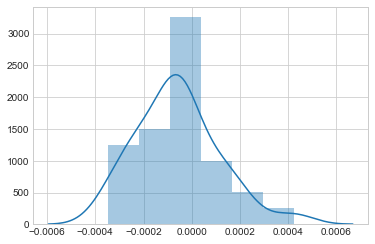

In [9]:
fig, ax = plt.subplots()
sns.distplot(slopes, ax=ax)
fig.show()

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


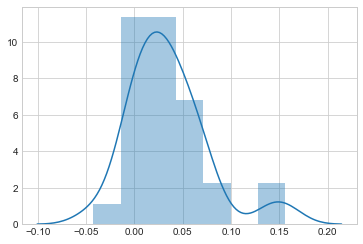

In [10]:
fig, ax = plt.subplots()
sns.distplot(intercepts, ax=ax)
fig.show()

Intercept is significant and positive, indicating that inclusion of high-motion volumes *increased* correlations between pair of ROIs.

Slope is not significant, indicating that inclusion of high-motion volumes *does not affect* correlations differentially for nearer ROIs compared to more distant ones.